In [ ]:
import networkx as nx
import json
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
print(torch.__version__)


2.0.0+cu118


In [ ]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-geometric
  !pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=a0f0c2c4d8d1ef03e0d22900071073d9d3a72c48c85b4ff91678996fa214206b
  Stored i

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from tqdm import tqdm
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_diag_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
import json
import pandas as pd
import networkx as nx
f = open('reddit_edges.json')
content = json.load(f)
df = pd.read_csv('reddit_target.csv')

G_list = list(content.values())
Gs = [nx.Graph(i) for i in G_list[0:1000]]
y = list(df.target)[0:1000]

In [ ]:
a = list(Gs[0].nodes)
# a = list(Gs[0].nodes)
# a = np.array(a)
# b = np.zeros((a.size, a.max()+1))
# b[np.arange(a.size), a] = 1
# b
# c = torch.tensor(b, dtype=torch.float)
# c
b=[]
for i in a:
  b.append([1])
b


[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]

In [ ]:
emb_list = []

for i in Gs:
  # a = list(i.nodes)
  # a = np.array(a)
  # b = np.zeros((a.size, a.max()+1))
  # b[np.arange(a.size), a] = 1
  # c = torch.tensor(b, dtype=torch.float)
  c=[]
  for a in list(i.nodes):
    c.append([1])
  c = torch.tensor(c, dtype=torch.float)
  emb_list.append(c)


In [ ]:
emb_list

In [ ]:
y = torch.tensor([[i] for i in y])

In [ ]:
edge_indices = []
for i in G_list[0:1000]:
  edge_indices.append(torch.tensor(i, dtype=torch.long).T)

In [ ]:

raw_data = list(zip(*(emb_list,edge_indices,y)))

In [ ]:
data = []
for i in raw_data:
  data.append(Data(x=i[0], y=i[2], edge_index=i[1]))

In [ ]:
trainset, testset= train_test_split(data, test_size=0.25, random_state=42)
# trainset, valset= train_test_split(trainset, test_size=0.2, random_state=42)

In [ ]:
ytrain = []
for i in trainset:
  ytrain.append(i.y.numpy()[0])

In [ ]:
ytest = []
for i in testset:
  ytest.append(i.y.numpy()[0])

<Axes: >

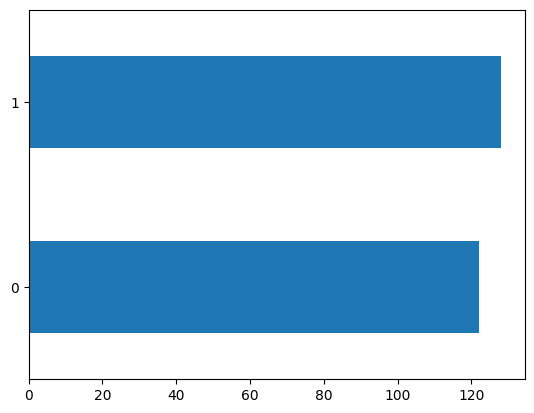

In [ ]:
pd.Series(ytest).value_counts().sort_values().plot(kind = 'barh')

In [ ]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
# valid_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
data[1].y

tensor([1])

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(123)
        self.conv1 = GraphConv(1, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        # self.conv3 = GraphConv(hidden_channels, hidden_channels)
        # self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.hidden1 = Linear(hidden_channels, hidden_channels)
        self.re1 = torch.nn.ReLU()
        self.hidden2 = Linear(hidden_channels, hidden_channels)
        self.re2 = torch.nn.ReLU()
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = self.bn3(x)
        # x = x.relu()
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.hidden1(x)
        x = self.re1(x)
        x = self.hidden2(x)
        x = self.re2(x)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256)
print(model)

GCN(
  (conv1): GraphConv(1, 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(256, 256)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=256, out_features=256, bias=True)
  (re1): ReLU()
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (re2): ReLU()
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 120):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.5053, Test Acc: 0.5120
Epoch: 002, Train Acc: 0.5053, Test Acc: 0.5120
Epoch: 003, Train Acc: 0.5053, Test Acc: 0.5120
Epoch: 004, Train Acc: 0.5053, Test Acc: 0.5120
Epoch: 005, Train Acc: 0.4987, Test Acc: 0.5000
Epoch: 006, Train Acc: 0.5160, Test Acc: 0.5320
Epoch: 007, Train Acc: 0.5773, Test Acc: 0.5960
Epoch: 008, Train Acc: 0.5787, Test Acc: 0.6080
Epoch: 009, Train Acc: 0.6000, Test Acc: 0.6160
Epoch: 010, Train Acc: 0.6227, Test Acc: 0.6320
Epoch: 011, Train Acc: 0.6307, Test Acc: 0.6360
Epoch: 012, Train Acc: 0.6267, Test Acc: 0.6400
Epoch: 013, Train Acc: 0.6293, Test Acc: 0.6200
Epoch: 014, Train Acc: 0.6533, Test Acc: 0.6360
Epoch: 015, Train Acc: 0.6520, Test Acc: 0.6440
Epoch: 016, Train Acc: 0.6547, Test Acc: 0.6480
Epoch: 017, Train Acc: 0.6493, Test Acc: 0.6360
Epoch: 018, Train Acc: 0.6440, Test Acc: 0.6200
Epoch: 019, Train Acc: 0.6533, Test Acc: 0.6360
Epoch: 020, Train Acc: 0.6560, Test Acc: 0.6400
Epoch: 021, Train Acc: 0.6533, Test Acc: